# Building heights by distance from a point

by Chris Prince [chrprince@gmail.com] - 12 May 2018

Similar analysis for Los Angeles as for the plots shown in this tweet:
https://twitter.com/geographyjim/status/994949659461341184

![building heights by distance for London and Paris](https://pbs.twimg.com/media/Dc7FSwFXkAA5-br.jpg:large)

### Imports:

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import pylab as pl
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
buildings = gpd.read_file('/home/cmp/data/LABuildings/LARIAC_Buildings_2014.gdb/', layer=1)

### Sources

**NYC**: https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh/data

Similar data exists for Chicago, but appears incomplete: https://data.cityofchicago.org/Buildings/Building-Footprints-deprecated-August-2015-/qv97-3bvb (and the current version may be broken) as of 12 May 2018.

**LA**: https://egis3.lacounty.gov/dataportal/2016/11/03/countywide-building-outlines-2014-update-public-domain-release/

Calculate centroids of the geometries

In [5]:
buildings = buildings[['HEIGHT','geometry']]

In [7]:
buildings['centroid'] = buildings.geometry.centroid

In [8]:
from shapely.geometry import Point

The coordinates for Pershing Square (per Google):

In [9]:
ps = Point(-118.2529,34.0486)

In [10]:
buildings.crs

{'init': u'epsg:2229'}

Some gymnastics to convert the lat/long of TS to CRS:

In [11]:
ps = gpd.geodataframe.GeoDataFrame([ps])
ps.geometry = ps[0]
ps.crs = ({'init' : 'epsg:4326'})
ps = ps.to_crs({'init' : 'epsg:2229'})
psft = ps.geometry

Distance calculations are done from the geometry attribute of the GeoDataFrame, so set the geometry to the centroid column:

In [12]:
buildings.geometry = buildings.centroid

In [13]:
buildings['dist'] = buildings.distance(psft[0])

In [14]:
ftPerMeter = 3.28084

In [15]:
buildings['dist_m'] = buildings['dist']/ftPerMeter

In [16]:
buildings['HEIGHT_m'] = buildings['HEIGHT']/ftPerMeter

Use seaborn defaults to emulate look of the source plots:

In [17]:
sns.set()

Drop zero-height entries and cutoff after 25 km:

In [18]:
b = buildings[buildings.HEIGHT_m>0]
b_25k = b[b.dist_m<25000]

A helper function for common labels:

In [27]:
def formatplot():
    pl.xticks(fontsize=14)
    pl.yticks(fontsize=14)
    ax.set_title("Building heights in LA by distance to Pershing Square (2014)", size=24)
    ax.set_ylabel("roof height (m)", size=18)
    ax.set_xlabel("distance to Pershing Square (m)", size=18)

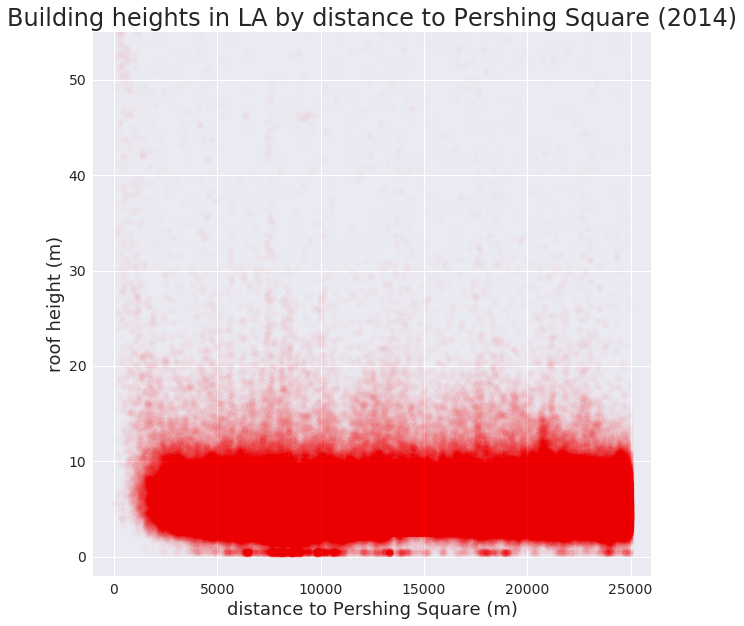

In [62]:
fig, ax=pl.subplots(figsize=(10,10))
pl.plot(b_25k.dist_m, b_25k.HEIGHT_m, 'o', color = 'r', alpha=0.01)
ax.set_xlim((-1000,26000))
ax.set_ylim((-2,55))
formatplot()
pl.savefig('la_bheights.png', bbox_inches='tight')


There isn't much of a population above 25 meters, and very few above 50 meters.

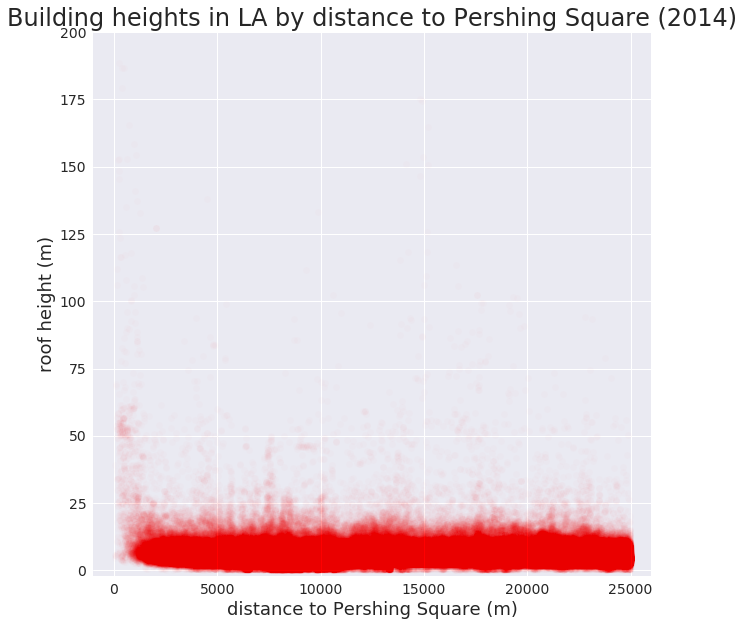

In [63]:
fig, ax=pl.subplots(figsize=(10,10))
pl.plot(b_25k.dist_m, b_25k.HEIGHT_m, 'o', color = 'r', alpha=0.01)
ax.set_xlim((-1000,26000))
ax.set_ylim((-2,200))
formatplot()

Buildings stay short throughtout the extent of the county.

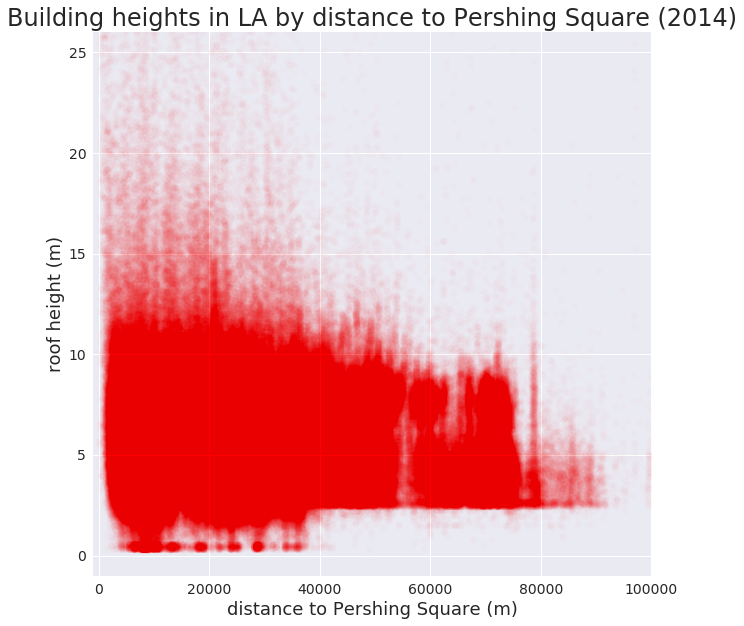

In [68]:
fig, ax=pl.subplots(figsize=(10,10))
pl.plot(b.dist_m, b.HEIGHT_m, 'o', color = 'r', alpha=0.01)
ax.set_xlim((-1000,100000))
ax.set_ylim((-1,26))
formatplot()

The density of the points makes this plot a little misleading; a histogram plotted on a logscale shows that 5 meter buildings are an order of magnitude more common than 10 meter buildings between 10 and 30 km from Pershing Square.

In [65]:
from matplotlib.colors import LogNorm

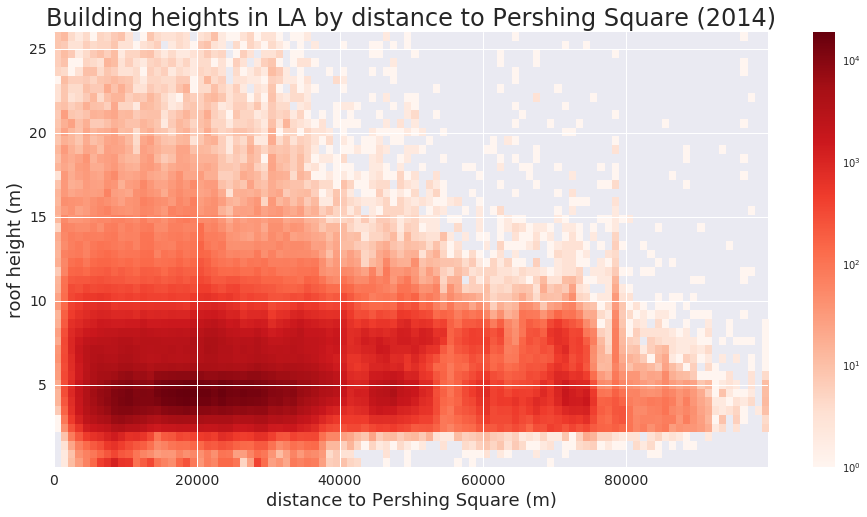

In [70]:
fig, ax=pl.subplots(figsize=(16,8))
b_100k = b[(b.HEIGHT_m<26)&(b.dist_m<100000)]
pl.hist2d(b_100k.dist_m, b_100k.HEIGHT_m, cmap='Reds', bins=[100,50], norm=LogNorm());
formatplot()
pl.colorbar()